# Interpretability Notebook

This notebook is a demo notebook for developing and prototyping some interpretability ideas on rPPG models

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("./code")

# hack to force TF to use CPU https://github.com/keras-team/keras/issues/4613
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

import pathlib
from aifc import Error
from pathlib import Path
from glob import glob
import pickle

import h5py

from IPython.display import HTML, Video

import matplotlib.pyplot as plt

import numpy as np

import scipy
from scipy import signal
from scipy.signal import butter

import tensorflow as tf

from inference_preprocess import preprocess_raw_video_, detrend
from model import CAN_3D,Hybrid_CAN
from pre_process import get_nframe_video, split_subj_, sort_video_list_, sort_dataFile_list_

import interp

There are two architectures available (CAN_3D and Hybrid_CAN) and you can select the same in the next code cell.
More information about these architectures can be found [here](https://papers.nips.cc/paper/2020/file/e1228be46de6a0234ac22ded31417bc7-Paper.pdf).

## Model and Data Setup

In [4]:
tf.config.list_physical_devices()

2023-06-15 13:32:17.416322: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-15 13:32:17.416366: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: vmc-mbp.GPU.CIT-EC.NET
2023-06-15 13:32:17.416373: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: vmc-mbp.GPU.CIT-EC.NET
2023-06-15 13:32:17.416501: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.41.3
2023-06-15 13:32:17.416527: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.41.3
2023-06-15 13:32:17.416532: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.41.3


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
#Configuration for the model
img_rows = 36
img_cols = 36
frame_depth = 10
batch_size = 100

sm = 'hy'

if sm == "3d":
    model_name = "CAN_3D"
    model_checkpoint_3d = "./checkpoints/ppg-3d-can.h5"
    with tf.device('/cpu:0'):
        model = CAN_3D(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3))
        model.load_weights(model_checkpoint_3d)
elif sm == "hy":
    model_name = "Hybrid_CAN"
    model_checkpoint_hy = "./checkpoints/ppg-hy-can.h5"
    with tf.device('/cpu:0'):
        model = Hybrid_CAN(frame_depth, 32, 64, (img_rows, img_cols, frame_depth, 3),
                            (img_rows, img_cols, 3))
        model.load_weights(model_checkpoint_hy)

print("Selected Model is:", model_name)

Selected Model is: Hybrid_CAN


2023-06-15 13:32:23.871962: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# model_checkpoint_hy = "./models/ppg-Hybrid_CAN-4-19/cv_0_epoch02_model.tf/"
# model_checkpoint_3d = "./models/ppg-CAN_3D-4-19/cv_0_epoch02_model.tf/"

#sample data path
data_path = "/data/rppg_22_bi_video_nt_lab/processed/p1/3/HREL_HIGH_dataFile.hdf5"

In [7]:
def prepare_3D_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (491, 10, 36, 36 ,6) (169, 10, 36, 36, 6)
                    for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    return tempX

def prepare_Hybrid_CAN(dXsub):
    frame_depth = 10
    num_window = int(dXsub.shape[0]) - frame_depth + 1
    tempX = np.array([dXsub[f:f + frame_depth, :, :, :] # (169, 10, 36, 36, 6)
                        for f in range(num_window)])
    tempX = np.swapaxes(tempX, 1, 3) # (169, 36, 36, 10, 6)
    tempX = np.swapaxes(tempX, 1, 2) # (169, 36, 36, 10, 6)
    motion_data = tempX[:, :, :, :, :3]
    apperance_data = np.average(tempX[:, :, :, :, -3:], axis=-2)
    return motion_data, apperance_data

In [8]:
#load the processed data that is scaled and normalized
data = h5py.File(data_path, "r")
dXsub = np.array(data["data"])
dXsub_len = (dXsub.shape[0] // frame_depth) * frame_depth
dXsub = dXsub[:dXsub_len, :, :, :]
pulse_truth = np.array(data["pulse"])
data.close()
#FPS/sampling frequency of the ground truth data
fs = 25

In [9]:
data = h5py.File(data_path, "r")
d_in = np.array(data["data"])
d_in.shape

(1499, 36, 36, 6)

In [10]:
d_in2 = prepare_Hybrid_CAN(d_in)
d_in2[1].shape

(1490, 36, 36, 3)

In [11]:
# rPPG estimation of the processed video
if model_name == "CAN_3D":
    dXsub = prepare_3D_CAN(dXsub)
    dXsub_len = (dXsub.shape[0] // (frame_depth))  * (frame_depth)
    dXsub = dXsub[:dXsub_len, :, :, :,:]
    inputs = (dXsub[:, :, :,: , :3], dXsub[:, :, :, : , -3:])
    yptest = model.predict(inputs, verbose=1)
elif model_name == "Hybrid_CAN":
    dXsub1, dXsub2 = prepare_Hybrid_CAN(dXsub)
    dXsub_len1 = (dXsub1.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub1 = dXsub1[:dXsub_len1, :, :, :, :]
    dXsub_len2 = (dXsub2.shape[0] // (frame_depth*10))  * (frame_depth*10)
    dXsub2 = dXsub2[:dXsub_len2, :, :, :]
    inputs = (dXsub1, dXsub2)
    yptest = model.predict(inputs, verbose=1)
else:
    raise NotImplementedError
    
if model_name == "CAN_3D" or model_name == "Hybrid_CAN":
    pulse_pred = yptest[:,0]       
else:
    raise NotImplementedError
 

2023-06-15 13:32:41.669478: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 217728000 exceeds 10% of free system memory.


44/44 [==============================] - 3s 46ms/step


In [12]:
def HR_estimate(input_signal):
    '''Estimate the HR using the PSD of the rPPG signal'''
    #estimating HR from the predicted rPPG signal
    pulse_pred = detrend(np.cumsum(input_signal), 100)
    [b_pulse_pred, a_pulse_pred] = butter(1, [0.75 / fs * 2, 3.5 / fs * 2], btype='bandpass')
    pulse_pred = scipy.signal.filtfilt(b_pulse_pred, a_pulse_pred, np.double(pulse_pred))

    N = 30 * fs
    pulse_fft = np.expand_dims(pulse_pred, 0)
    f, pxx = signal.periodogram(pulse_fft, fs=fs, nfft=4 * N, detrend=False)
    fmask = np.argwhere((f >= 0.75) & (f <= 3.5))  # regular Heart beat are 0.75*60 and 2.5*60
    frange = np.take(f, fmask)
    HR = np.take(frange, np.argmax(np.take(pxx, fmask), 0))[0] * 60
    return HR


HR_pred = HR_estimate(pulse_pred)
HR_truth = HR_estimate(pulse_truth)

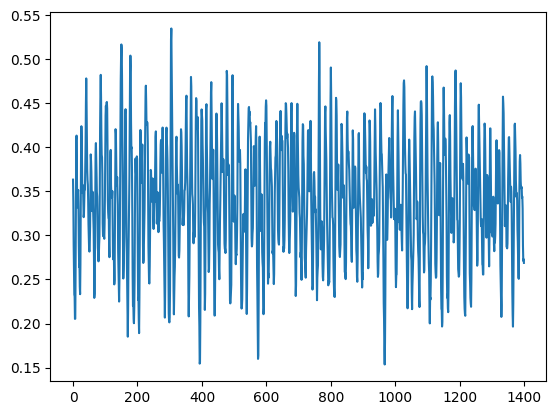

In [13]:
plt.plot(pulse_pred)

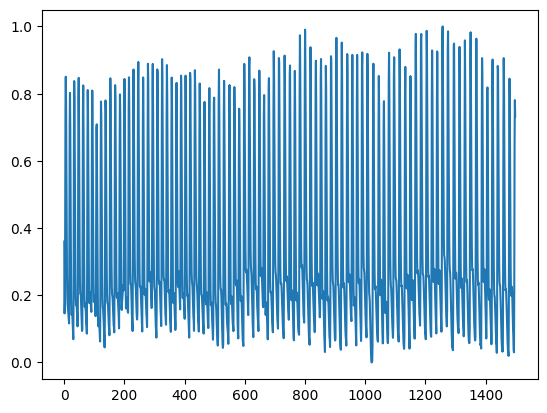

In [14]:
plt.plot(pulse_truth)

In [15]:
HR_truth, HR_pred

(86.0, 97.0)

## Interpretability Methods

In [16]:
# Print summary to find name of last 2D CNN layer
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 36, 36, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 36, 36, 32)   896         ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 34, 34, 32)   9248        ['conv2d[0][0]']                 
                                                                                                  
 average_pooling2d (AveragePool  (None, 17, 17, 32)  0           ['conv2d_1[0][0]']               
 ing2D)                                                                                       

In [17]:
# setup variables 
last_conv_layer_name_app = 'conv2d_4'

fps = 24

diffs = inputs[0]
imgs = inputs[1]

# average image from input to appearance branch used for static visualizations
img = np.squeeze(np.mean(imgs, axis=0))
img = (img-np.min(img))/(np.max(img)-np.min(img)) #normalize to values between [0, 1] (but should check pre-processing normalization for true denormalization) also maybe should normalize each img before taking mean

### Gradient-weighted Regression Activation Maps

#### Appearance Branch - Full Participant

Regression Activation Maps for the Appearance Branch.  RAMs are calculated similar to GradCAM but using the regression output rather than a class label output.  

The videos are simply a concatentation of the RAMs for each of the participant's input frames.

In [18]:
hms = interp.make_gradcam_heatmap(inputs, model, last_conv_layer_name_app)
hm_mean = np.mean(hms, axis=0) # aggregate all heatmaps for entire video

2023-06-15 13:32:51.957118: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 217728000 exceeds 10% of free system memory.
2023-06-15 13:32:52.280898: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 232243200 exceeds 10% of free system memory.
2023-06-15 13:32:52.319378: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 232243200 exceeds 10% of free system memory.
2023-06-15 13:32:52.355178: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 232243200 exceeds 10% of free system memory.


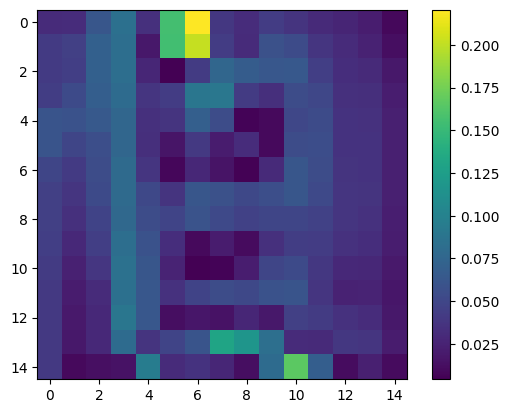

In [19]:
plt.imshow(np.squeeze(hm_mean))
plt.colorbar();

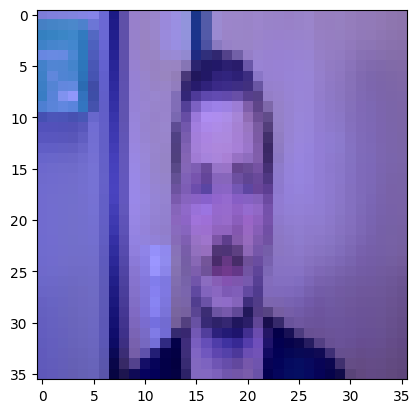

In [20]:
# get final output with interpolated activation values
gradcam = interp.superimpose(img, hm_mean, alpha=0.4)
plt.imshow(gradcam)

In [21]:
anim = interp.generate_animation(hms, imgs, fps, title='Gradient Weighted Activation Maps', alpha=0.4)
HTML(anim.to_html5_video())

#### Single Sample Activations

In [22]:
part_frame = 30

frame_img = imgs[part_frame]
frame_img = (frame_img-np.min(frame_img))/(np.max(frame_img)-np.min(frame_img))

##### Appearance Branch

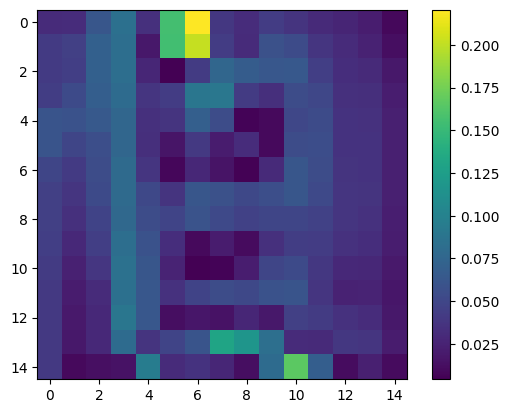

In [23]:
grad_ram = interp.make_gradcam_heatmap((inputs[0][part_frame:part_frame+1], inputs[1][part_frame:part_frame+1]), model, last_conv_layer_name_app)
plt.imshow(np.squeeze(hm_mean))
plt.colorbar();

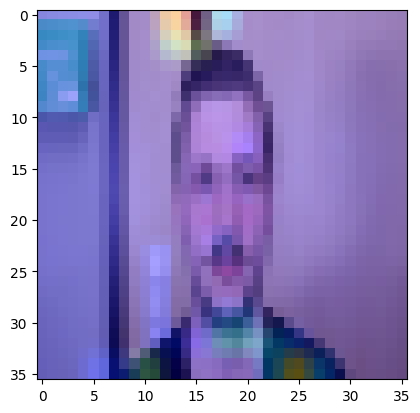

In [24]:
gradcam = interp.superimpose(frame_img, np.squeeze(grad_ram), alpha=0.4)
plt.imshow(gradcam)

##### Motion Branch - 3D Activations

Here we look at the 3D activations of the Motion branch by calculated the Activation Maps of the CNN output this branch. 
For a motion branch input of size $36 \times 36 \times 10 \times 3$, the motion branch CNN output 3D features maps of size $15 \times 15 \times 2 \times 64$.
To deal with the 3D feature maps, I first aggregate the 64 features maps for each of the 2 time steps similiar to GradCAM.
Then, we can look at each time steps feature maps.
Additionally, I have tried to make a video of the output by interpolating between the the 2 time steps into 10 frames (like the original input).
This is similar to how Activation Maps handle the height and width dimensions to upscale the activaation maps to the same size as the original image.

In [43]:
inputs[0][part_frame:part_frame+1].shape

(1, 36, 36, 10, 3)

In [25]:
last_conv_layer_motion = 'conv3d_3'
grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_motion).output, model.output]
    )
with tf.GradientTape() as tape:
    last_conv_layer_output, preds = grad_model((inputs[0][part_frame:part_frame+1], inputs[1][part_frame:part_frame+1]))
    pulse_pred = preds[:, 0]    # first output per input image
    
grads = tape.gradient(pulse_pred, last_conv_layer_output)
grads.shape, last_conv_layer_output.shape

(TensorShape([1, 15, 15, 2, 64]), TensorShape([1, 15, 15, 2, 64]))

In [26]:
pooled_grads = tf.reduce_mean(grads, axis=(1, 2, 3))
pooled_grads.shape

TensorShape([1, 64])

In [27]:
heatmaps = []
for out, pg in zip(last_conv_layer_output, pooled_grads):
    # heatmap = np.sum(out, axis=2) @ pg[..., tf.newaxis] # TODO: how best to aggregate 3d feature maps
    heatmap = out @ pg[..., tf.newaxis] # TODO: how best to aggregate 3d feature maps
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)    # apply ReLU to filter negative activations and normalize (each heatmap is independent of others in teh batch so normalize independelty)
    heatmaps.append(np.squeeze(heatmap))
    
heatmaps = np.array(heatmaps)
heatmaps.shape

(1, 15, 15, 2)

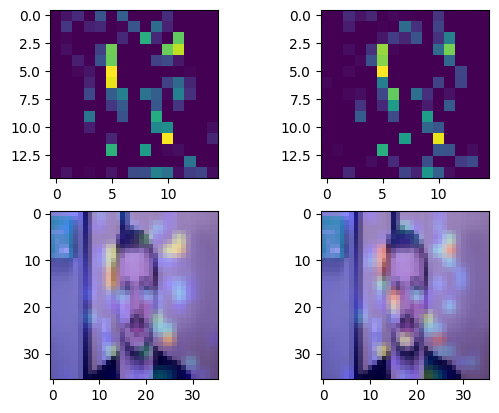

In [28]:
plt.figure()
plt.subplot(221)
plt.imshow(heatmaps[0,:,:, 0])
plt.subplot(222)
plt.imshow(heatmaps[0,:,:, 1])
plt.subplot(223)
hm0 = interp.superimpose(frame_img, heatmaps[0,:,:, 0], alpha=0.4)
plt.imshow(hm0)
plt.subplot(224)
hm1 = interp.superimpose(frame_img, heatmaps[0,:,:, 1], alpha=0.4)
plt.imshow(hm1)

In [29]:
np.array([np.array(hm0), np.array(hm1)]).shape

(2, 36, 36, 3)

In [30]:
# interpolated video of each of the 2 time steps
hm_vid = interp.interpolate_video(np.array([np.array(hm0), np.array(hm1)]), 10) # complete loop

In [31]:
anim = interp.generate_video_animation(hm_vid, fps=25, title='3D Activation Vis')
HTML(anim.to_html5_video())

### Attention Mask Visualizations

Direct visualizations of the attention map outputs from the 2 attention layers.

The videos are simply a concatentation of the attention maps for each of the participant's input frames.

#### Full Participant Sequence

In [32]:
# setup model to get output of attention layers
attention_layers = ['attention_mask', 'attention_mask_1']
attn_model = tf.keras.models.Model(
    [model.inputs], [model.get_layer(l).output for l in attention_layers] + [model.output]
)

In [33]:
# get model outputs and attention maps
# for each input frame there is one activate map for each attention laye
attn0, attn1, preds = attn_model(inputs)

# normalize for visualization
attn0_norm = (attn0 - np.min(attn0)) / (np.max(attn0)-np.min(attn0))
attn1_norm = (attn1 - np.min(attn1)) / (np.max(attn1)-np.min(attn1))
attn0_norm.shape, attn1_norm.shape

(TensorShape([1400, 34, 34, 1]), TensorShape([1400, 15, 15, 1]))

In [34]:
# aggregate attention maps
attn0_mean = tf.reduce_mean(attn0, axis=(0, -1))
attn1_mean = tf.reduce_mean(attn1, axis=(0, -1))

# normalize to between 0 and 1
attn0_mean = (attn0_mean-np.min(attn0_mean))/(np.max(attn0_mean)-np.min(attn0_mean))
attn1_mean = (attn1_mean-np.min(attn1_mean))/(np.max(attn1_mean)-np.min(attn1_mean))

##### Attention Layer 1 Visualizations

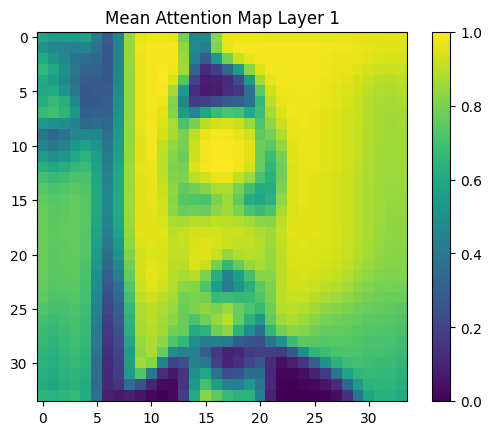

In [35]:
plt.imshow(attn0_mean)
plt.title('Mean Attention Map Layer 1')
plt.colorbar();

In [36]:
anim = interp.generate_animation(attn0_norm, imgs, fps, title='Attention Layer 1 Maps', alpha=0.4)
HTML(anim.to_html5_video())

##### Attention Layer 2 Visualizations

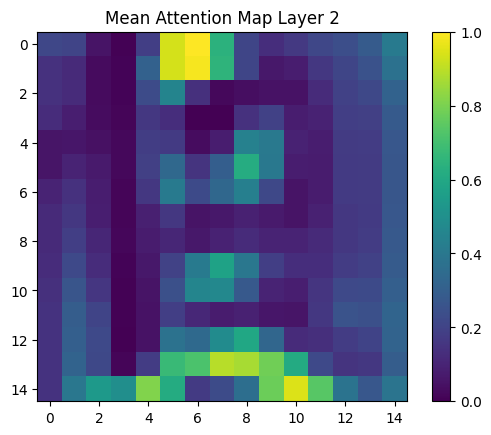

In [37]:
plt.imshow(attn1_mean)
plt.title('Mean Attention Map Layer 2')
plt.colorbar();

In [38]:
anim = interp.generate_animation(attn1_norm, imgs, fps, title='Attention Layer 2 Maps', alpha=0.4)
HTML(anim.to_html5_video())

#### Single Frame 

In [39]:
single_input = (inputs[0][part_frame:part_frame+1], inputs[1][part_frame:part_frame+1])

In [40]:
attn0, attn1, preds = attn_model(single_input)

# normalize for visualization
attn0_norm = (attn0 - np.min(attn0)) / (np.max(attn0)-np.min(attn0))
attn1_norm = (attn1 - np.min(attn1)) / (np.max(attn1)-np.min(attn1))
attn0_norm.shape, attn1_norm.shape

(TensorShape([1, 34, 34, 1]), TensorShape([1, 15, 15, 1]))

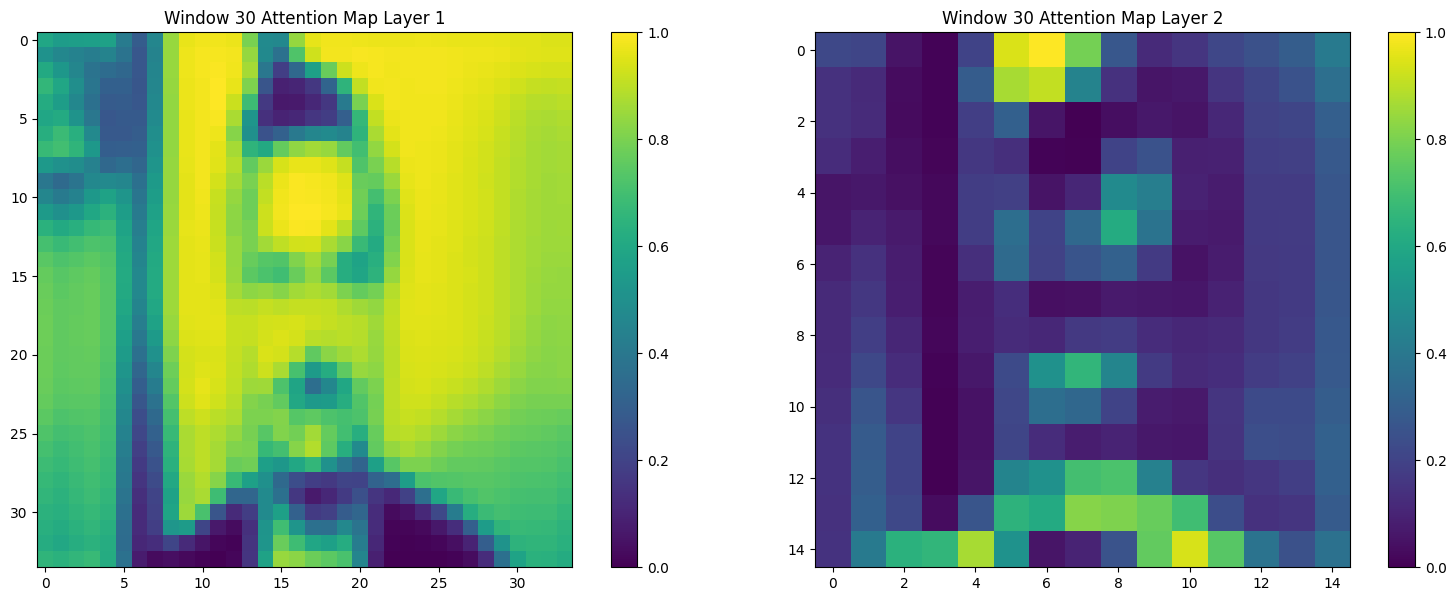

In [41]:
plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.imshow(np.squeeze(attn0_norm))
plt.title(f'Window {part_frame} Attention Map Layer 1')
plt.colorbar();
plt.subplot(122)
plt.imshow(np.squeeze(attn1_norm))
plt.title(f'Window {part_frame} Attention Map Layer 2')
plt.colorbar()
plt.tight_layout();

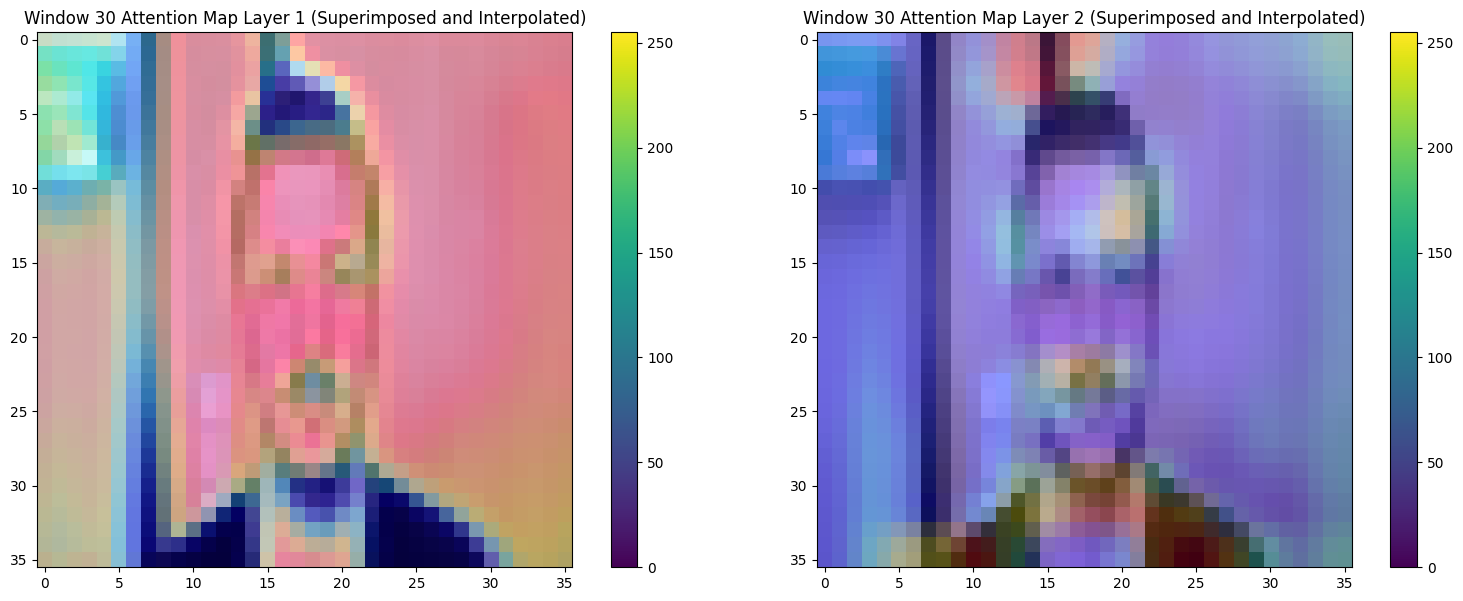

In [42]:
hm0 = interp.superimpose(frame_img, heatmaps[0,:,:, 0], alpha=0.4)

plt.figure(figsize=(16, 6))
plt.subplot(121)
img = interp.superimpose(frame_img, np.squeeze(attn0_norm), alpha=0.4)
plt.imshow(img)
plt.title(f'Window {part_frame} Attention Map Layer 1 (Superimposed and Interpolated)')
plt.colorbar();
plt.subplot(122)
img = interp.superimpose(frame_img, np.squeeze(attn1_norm), alpha=0.4)
plt.imshow(img)
plt.title(f'Window {part_frame} Attention Map Layer 2 (Superimposed and Interpolated)')
plt.colorbar()
plt.tight_layout();